# Time Series Forecasting with Machine Learning
## Objective: Predict whether the price of a stock will open green or red on the next day, using past OHLC time series data
## Steps:
##### 1. Get Data: We need data to train our model
##### 2. Prepare Data: Clean, normalize, and get data in a form that we can feed into our model
##### 3. Train Model: Feed in prepared to our Model
##### 4. Evaluate and Fix: Does the Model work? Also, fix any bugs common Machine Learning bugs that may have appeared
##### 5. Develop Trading Algorithm: Backtest ML Model based Algorithm
##### 6. Analyze Performance: Measure performance and risk of our Trading Algorithm
##### 7. ???
##### 8. Profits $$$: Go live and lose money (well hopefully not)


In [34]:
from yahoo_fin.stock_info import get_data
import numpy as np


def get_ml_formatted_data(ticker, start_date='01/01/2015', end_date='01/01/2020'):
    # STEP 1: get data
    df = get_data(ticker=ticker,start_date=start_date, end_date=end_date)
    
    # STEP 2: prepare data
    del df['ticker']
    del df['adjclose']
    del df['volume']
    # pct_change() is our normalization step
    x = df.pct_change()
    x = x.iloc[1:]
    df = df.iloc[1:]
    x.reset_index(drop=True, inplace=True)

    def cust_filter(row):
        if (row.name + 1) % 6 == 0:
            return int(row['open'] > 0)
        else:
            return float('NaN')
    
    # separate DF's can be used to store following data,
    # but attaching the data makes for easier bebugging
    x['opened_up'] = x.apply(cust_filter, axis=1)
    labels = x['opened_up'].dropna().values.astype(int)
    del x['opened_up']

    # flatten() makes it so we can put it through our model
    chunks = [x[a:a+5].values.flatten() for a in range(0, len(x), 6)]

    # sometimes there is an extra chunk of a few rows at the end that we don't want
    if len(chunks) > len(labels):
        chunks.pop(-1)
    data = np.asarray(chunks)
    
    # close_values and open_values will be used later to backtest our algorithm
    # close_values are the closing prices on the day before 
    # the day we are trying to predict whether the stock will open green or red
    # open_values are the actual open prices of the stock of the day we are trying to predict 
    # whether the stock open will open green or red
    close_values = df['close'].iloc[4::6].values
    open_values = df['open'].iloc[5::6].values
    return data, labels, close_values, open_values

# same as above except more than 1 ticker can be used
def get_ml_data_multiple_tickers(tickers_list, start_date='01/01/2015', end_date='01/01/2020'):
    data_list = []
    labels_list = []
    close_values_list = []
    open_values_list = []
    for ticker in tickers_list:
        data, labels, close_values, open_values = get_ml_formatted_data(ticker, start_date=start_date, end_date=end_date)
        data_list.extend(data)
        labels_list.append(labels)
        close_values_list.append(close_values)
        open_values_list.append(open_values)
    # np.append combines a list of numpy arrays into one
    #return np.asarray(data_list), np.append([], labels_list), np.append([], close_values_list), np.append([], open_values_list)
    return np.asarray(data_list), np.concatenate(labels_list, axis=None),\
            np.concatenate(close_values_list, axis=None), np.concatenate(open_values_list, axis=None)

In [35]:
from get_all_tickers.get_tickers import get_tickers_filtered

ticker = get_tickers_filtered(mktcap_min=200000)

data, labels, _, _ = get_ml_data_multiple_tickers(tickers, start_date='01/01/2000', end_date='01/01/2019')

#STEP 3: Train Model
model = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(8,8,8),max_iter=1000, activation='tanh', random_state=42)
# Explanation of parameters:
# lbfgs converges fast for small datasets
# hidden layers are basically the neurons in between the input and output, I made 3 layers, 
# size with 2 times the feature count- 4 (1-Open 2-High 3-Low 4-Close)
# activation using tanh prevents neuron deaths. neuron deaths cause all outputs to become 0 or all become 1
# setting random_state to an integer (can be basically any int) makes model deterministic
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.5)
model.fit(X_train, y_train)

# get what the model predicts, so we can compare with actual
predicted = model.predict(X_test)

# STEP 4: Evaluate Model
print(metrics.classification_report(y_test, predicted))
print('Accuracy:', metrics.accuracy_score(y_test, predicted))

             precision    recall  f1-score   support

          0       0.83      0.79      0.81      3713
          1       0.81      0.84      0.83      3975

avg / total       0.82      0.82      0.82      7688

Accuracy: 0.8172476586888657


C:\Users\pickl\Anaconda3\lib\site-packages\trade_stat_logger\logger.py:115: UserWarning: For most accurate performance results, please clear all holdings, which you can do with clear_all_positions()
  warn('For most accurate performance results, please clear all holdings, which you can do with clear_all_positions()')


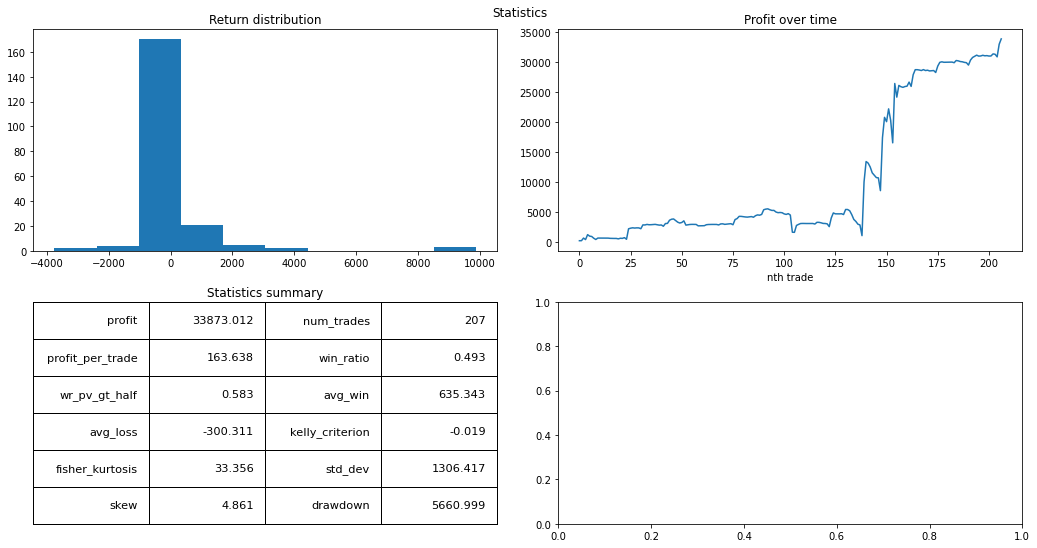

In [36]:
# unfortunately, lbfgs solver method doesn't allow partial fits to data. 
# We could use SGD to access partial_fit, however, SGD convgerges too slowly
model.fit(data, labels)

# STEP 5: Develop trading algorithm
from trade_stat_logger.logger import SimpleLogger

# we could try to match each data point with the corresponding ticker
# however, since we log buys and sells instantly it doesn't matter
ticker = 'ANON'

logger = SimpleLogger()

data, labels, close_vals, open_vals = get_ml_data_multiple_tickers(tickers, start_date='01/10/2019', end_date='05/01/2020')

def get_prediction_values(data):
    # need to encapsulate 1D data in a list b/c sklearn models 
    # don't take single input values
    value = model.predict([data])[0]
    certainty = np.amax(model.predict_proba([data])[0])
    return value, certainty

for i in range(len(labels)):
    value, certainty = get_prediction_values(data[i])
    if certainty > .95:
        if value:
            logger.log(security=ticker, share_price=close_vals[i], shares=100)
            logger.log(security=ticker, share_price=open_vals[i], shares=-100)
        else:
            logger.log(security=ticker, share_price=close_vals[i], shares=-100)
            logger.log(security=ticker, share_price=open_vals[i], shares=100)

# STEP 6: Evaluate Algorithm
logger.graph_statistics()
